### Validate CDSS Against NEST Study

For each patient week we compare the clinicians decisions took vs the decisions the CDSS engine would have taken.

---

In [1]:
nest_patient = [
    775,  787,  788, 1123, 1169, 1170, 1171, 1172, 1173, 1983, 2110, 2195,
    2955, 2956, 2957, 2958, 2959, 2960, 2961, 2962, 2963, 3081, 3229, 3318, 3432
]

In [2]:
rgs_mode = "app"
scoring_weights = [1,1,1]
ewma_alpha = 0.5

n = 12
days = 7
protocols_per_day = 5

### 1. Load Data

In [3]:
from ai_cdss.data_loader import DataLoader
from ai_cdss.data_processor import DataProcessor

In [4]:
loader = DataLoader(rgs_mode=rgs_mode)
processor = DataProcessor(weights=scoring_weights, alpha=ewma_alpha)

In [5]:
session = loader.load_session_data(patient_list=nest_patient)
timeseries = loader.load_timeseries_data(patient_list=nest_patient)
ppf = loader.load_ppf_data(patient_list=nest_patient)
protocol_similarity = loader.load_protocol_similarity()

Database engine created successfully


INFO:ai_cdss.data_loader:Session data loaded successfully.


Database engine closed
Database engine created successfully
Database engine closed
Database engine created successfully
Database engine closed


INFO:ai_cdss.data_loader:PPF data loaded successfully.
INFO:ai_cdss.data_loader:Protocol similarity data loaded successfully.


In [6]:
session_clean = session.drop(session.columns[1:15], axis=1)

In [7]:
# Get nest data merged with metrics semi computed
data = processor.merge_session_and_timeseries(session_data=session_clean, timeseries_data=timeseries)

In [8]:
from ai_cdss.processing import expand_session_batch
session_all = expand_session_batch(session)
session_all_clean = session_all.drop(session_all.columns[1:15], axis=1)

/home/dav/Documents/AISN/ai-cdss/src/ai_cdss/processing.py:186: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sessions_df = pd.concat([session, df_missing], ignore_index=True)


### 1.2 Weekly Data

In [9]:
import pandas as pd

def iterate_cumulative_weekly_data(df):
    """
    Iterates over patient session data on a cumulative weekly basis.

    Parameters:
        df (pd.DataFrame): DataFrame containing session records with 'SESSION_DATE'.

    Yields:
        tuple: (week_number, cumulative_dataframe)
    """
    # Ensure SESSION_DATE is in datetime format
    df = df.copy()  # Create a new DataFrame to avoid modifying the original
    df["SESSION_DATE"] = pd.to_datetime(df["SESSION_DATE"], errors="coerce")

    # Drop rows where SESSION_DATE is NaT (missing)
    df = df.dropna(subset=["SESSION_DATE"]).copy()

    # Create 'YEAR_WEEK' column safely
    df.loc[:, "YEAR_WEEK"] = df["SESSION_DATE"].dt.strftime('%Y-%W')

    # Sort by date to ensure cumulative computation is correct
    df = df.sort_values(by="SESSION_DATE").copy()

    # Track cumulative data
    cumulative_df = pd.DataFrame()

    # Ensure unique weeks are sorted correctly
    for week in sorted(df["YEAR_WEEK"].dropna().astype(str).unique()):
        # Select all data up to the current week
        current_data = df[df["YEAR_WEEK"] <= week]
        
        # Append to cumulative dataset
        cumulative_df = pd.concat([cumulative_df, current_data]).drop_duplicates()

        yield week, cumulative_df.copy()  # Return a copy to prevent modification issues

def iterate_weekly_data(df):
    """
    Iterates over weekly patient session data.

    Parameters:
        df (pd.DataFrame): DataFrame containing session records with a 'SESSION_DATE' column.

    Yields:
        tuple: (week_number, weekly_dataframe)
    """
    # Ensure SESSION_DATE is datetime format
    df["SESSION_DATE"] = pd.to_datetime(df["SESSION_DATE"])

    # Create a 'YEAR_WEEK' column to group by year and week
    df["YEAR_WEEK"] = df["SESSION_DATE"].dt.strftime('%Y-%W')

    # Iterate through each week's data
    for week, weekly_df in df.groupby("YEAR_WEEK"):
        yield week, weekly_df

In [12]:
from ai_cdss.cdss import CDSS
import matplotlib.pyplot as plt

2024-13


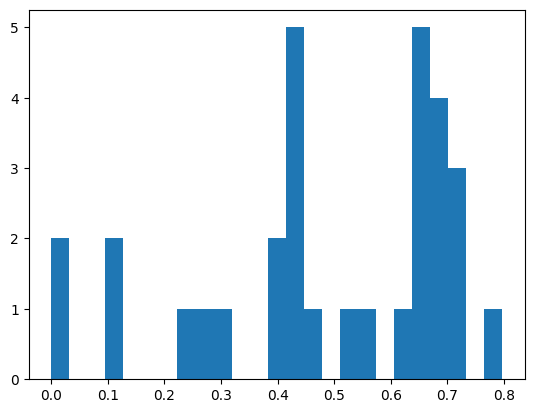

,PATIENT_ID,PROTOCOL_ID,PPF,CONTRIB,ADHERENCE,DM_VALUE,PE_VALUE,USAGE,DAYS,SCORE
38,775,206,0.528646,"[0.013972368519644753, 0.13972368519644754, 0....",1.0,0.000000,0.000000,1,[4],1.528646
45,775,222,0.632038,"[0.022302696143133578, 0.07434232047711194, 0....",1.0,0.000000,0.000000,1,[4],1.632038
46,775,224,0.632038,"[0.022302696143133578, 0.07434232047711194, 0....",1.0,0.578989,0.700713,13,[4],2.211028


-----------------


,PATIENT_ID,PROTOCOL_ID,PPF,CONTRIB,ADHERENCE,DM_VALUE,PE_VALUE,USAGE,DAYS,SCORE
0,775,201,0.632038,"[0.022302696143133578, 0.07434232047711194, 0....",0.0,0.000000,0.000000,0,[4],0.632038
1,775,219,0.631371,"[0.016784244244057927, 0.16784244244057928, 0....",0.0,0.000000,0.000000,0,[4],0.631371
2,775,224,0.632038,"[0.022302696143133578, 0.07434232047711194, 0....",1.0,0.578989,0.700713,13,[4],2.211028


2024-14


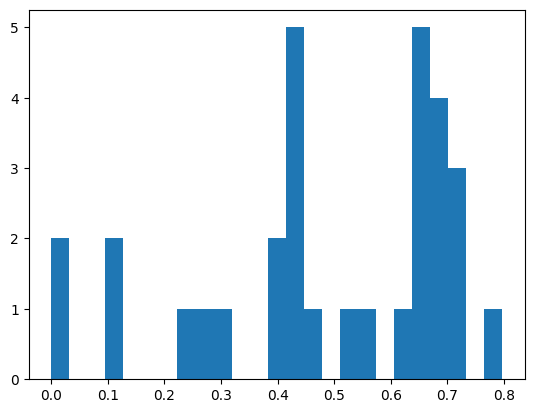

,PATIENT_ID,PROTOCOL_ID,PPF,CONTRIB,ADHERENCE,DM_VALUE,PE_VALUE,USAGE,DAYS,SCORE
38,775,206,0.528646,"[0.013972368519644753, 0.13972368519644754, 0....",1.0,0.000000,0.000000,3,"[0, 4]",1.528646
31,775,214,0.617411,"[0.014909525935815035, 0.04969841978605012, 0....",1.0,0.449279,0.500382,43,[2],2.066691
45,775,222,0.632038,"[0.022302696143133578, 0.07434232047711194, 0....",1.0,1.000000,0.953489,56,"[0, 4]",2.632038
46,775,224,0.632038,"[0.022302696143133578, 0.07434232047711194, 0....",1.0,0.717520,0.946096,31,"[0, 4]",2.349559
48,775,227,0.097419,"[0.03404920730373373, 0.0, 0.0, 0.0, 0.0, 0.01...",1.0,0.000000,0.000000,1,[2],1.097419


-----------------


,PATIENT_ID,PROTOCOL_ID,PPF,CONTRIB,ADHERENCE,DM_VALUE,PE_VALUE,USAGE,DAYS,SCORE
0,775,214,0.617411,"[0.014909525935815035, 0.04969841978605012, 0....",1.0,0.449279,0.500382,43,[2],2.066691
1,775,219,0.631371,"[0.016784244244057927, 0.16784244244057928, 0....",0.0,0.000000,0.000000,0,"[0, 4]",0.631371
2,775,222,0.632038,"[0.022302696143133578, 0.07434232047711194, 0....",1.0,1.000000,0.953489,56,"[0, 4]",2.632038
3,775,224,0.632038,"[0.022302696143133578, 0.07434232047711194, 0....",1.0,0.717520,0.946096,31,"[0, 4]",2.349559
4,775,225,0.084655,"[0.040365265686772116, 0.0, 0.0, 0.0, 0.0, 0.0...",0.0,0.000000,0.000000,0,[2],0.084655


2024-15


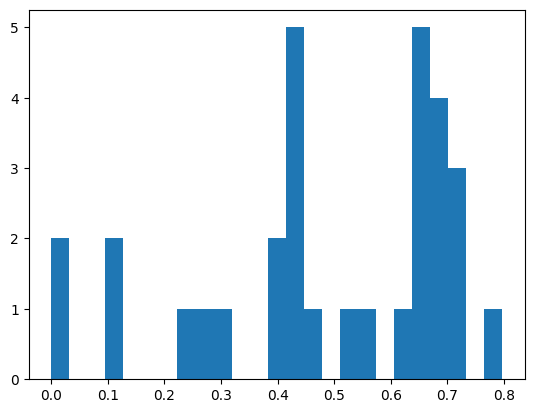

,PATIENT_ID,PROTOCOL_ID,PPF,CONTRIB,ADHERENCE,DM_VALUE,PE_VALUE,USAGE,DAYS,SCORE
38,775,206,0.528646,"[0.013972368519644753, 0.13972368519644754, 0....",1.0,0.047196,0.272135,20,"[0, 4]",1.575842
31,775,214,0.617411,"[0.014909525935815035, 0.04969841978605012, 0....",1.0,0.449279,0.500382,43,[2],2.066691
45,775,222,0.632038,"[0.022302696143133578, 0.07434232047711194, 0....",1.0,1.000000,1.000000,90,"[0, 4]",2.632038
46,775,224,0.632038,"[0.022302696143133578, 0.07434232047711194, 0....",1.0,0.472793,0.513876,38,"[0, 4]",2.104832
48,775,227,0.097419,"[0.03404920730373373, 0.0, 0.0, 0.0, 0.0, 0.01...",1.0,0.000000,0.000000,1,[2],1.097419


-----------------


,PATIENT_ID,PROTOCOL_ID,PPF,CONTRIB,ADHERENCE,DM_VALUE,PE_VALUE,USAGE,DAYS,SCORE
0,775,214,0.617411,"[0.014909525935815035, 0.04969841978605012, 0....",1.0,0.449279,0.500382,43,[2],2.066691
1,775,219,0.631371,"[0.016784244244057927, 0.16784244244057928, 0....",0.0,0.000000,0.000000,0,"[0, 4]",0.631371
2,775,222,0.632038,"[0.022302696143133578, 0.07434232047711194, 0....",1.0,1.000000,1.000000,90,"[0, 4]",2.632038
3,775,224,0.632038,"[0.022302696143133578, 0.07434232047711194, 0....",1.0,0.472793,0.513876,38,"[0, 4]",2.104832
4,775,225,0.084655,"[0.040365265686772116, 0.0, 0.0, 0.0, 0.0, 0.0...",0.0,0.000000,0.000000,0,[2],0.084655


2024-16


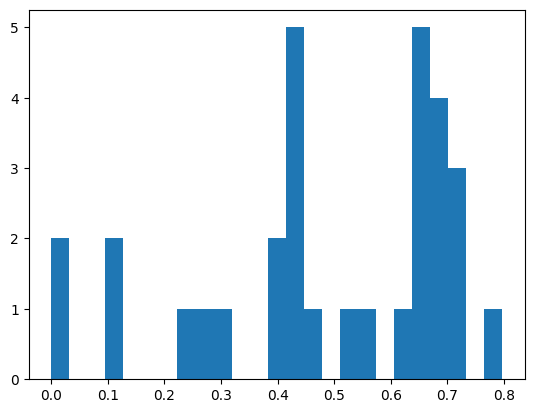

,PATIENT_ID,PROTOCOL_ID,PPF,CONTRIB,ADHERENCE,DM_VALUE,PE_VALUE,USAGE,DAYS,SCORE
38,775,206,0.528646,"[0.013972368519644753, 0.13972368519644754, 0....",1.000000,0.903403,0.988817,34,"[0, 4]",2.432049
33,775,208,0.484665,"[0.02088597029033065, 0.13923980193553767, 0.0...",1.000000,0.685836,0.618584,30,[4],2.170501
31,775,214,0.617411,"[0.014909525935815035, 0.04969841978605012, 0....",1.000000,0.949640,0.686718,77,[2],2.567052
45,775,222,0.632038,"[0.022302696143133578, 0.07434232047711194, 0....",0.771429,0.999805,0.872721,123,"[0, 4]",2.403272
46,775,224,0.632038,"[0.022302696143133578, 0.07434232047711194, 0....",1.000000,0.641686,0.819704,49,"[0, 4]",2.273724
48,775,227,0.097419,"[0.03404920730373373, 0.0, 0.0, 0.0, 0.0, 0.01...",1.000000,0.000000,0.000000,2,[2],1.097419


-----------------


,PATIENT_ID,PROTOCOL_ID,PPF,CONTRIB,ADHERENCE,DM_VALUE,PE_VALUE,USAGE,DAYS,SCORE
0,775,206,0.528646,"[0.013972368519644753, 0.13972368519644754, 0....",1.000000,0.903403,0.988817,34,"[0, 4]",2.432049
1,775,208,0.484665,"[0.02088597029033065, 0.13923980193553767, 0.0...",1.000000,0.685836,0.618584,30,[4],2.170501
2,775,214,0.617411,"[0.014909525935815035, 0.04969841978605012, 0....",1.000000,0.949640,0.686718,77,[2],2.567052
3,775,222,0.632038,"[0.022302696143133578, 0.07434232047711194, 0....",0.771429,0.999805,0.872721,123,"[0, 4]",2.403272
4,775,224,0.632038,"[0.022302696143133578, 0.07434232047711194, 0....",1.000000,0.641686,0.819704,49,"[0, 4]",2.273724
5,775,225,0.084655,"[0.040365265686772116, 0.0, 0.0, 0.0, 0.0, 0.0...",0.000000,0.000000,0.000000,0,[2],0.084655


2024-17


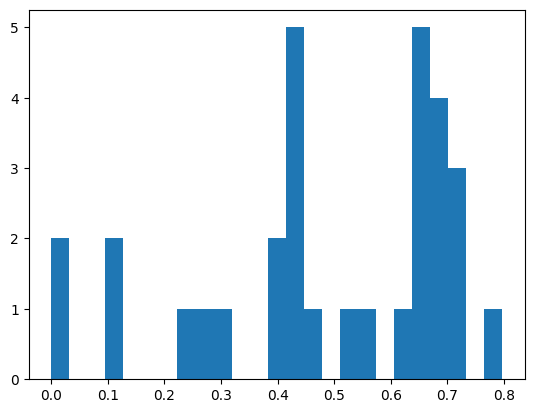

,PATIENT_ID,PROTOCOL_ID,PPF,CONTRIB,ADHERENCE,DM_VALUE,PE_VALUE,USAGE,DAYS,SCORE
38,775,206,0.528646,"[0.013972368519644753, 0.13972368519644754, 0....",1.000000,0.999906,0.993485,45,"[0, 4]",2.528552
33,775,208,0.484665,"[0.02088597029033065, 0.13923980193553767, 0.0...",0.908889,0.547420,0.789829,64,"[0, 4]",1.940973
31,775,214,0.617411,"[0.014909525935815035, 0.04969841978605012, 0....",1.000000,0.949640,0.686718,77,[2],2.567052
45,775,222,0.632038,"[0.022302696143133578, 0.07434232047711194, 0....",0.943529,1.000000,0.990234,158,"[0, 4]",2.575568
46,775,224,0.632038,"[0.022302696143133578, 0.07434232047711194, 0....",1.000000,0.644791,0.598725,65,"[0, 4]",2.276830
48,775,227,0.097419,"[0.03404920730373373, 0.0, 0.0, 0.0, 0.0, 0.01...",1.000000,0.000000,0.000000,2,[2],1.097419


-----------------


,PATIENT_ID,PROTOCOL_ID,PPF,CONTRIB,ADHERENCE,DM_VALUE,PE_VALUE,USAGE,DAYS,SCORE
0,775,206,0.528646,"[0.013972368519644753, 0.13972368519644754, 0....",1.000000,0.999906,0.993485,45,"[0, 4]",2.528552
1,775,214,0.617411,"[0.014909525935815035, 0.04969841978605012, 0....",1.000000,0.949640,0.686718,77,[2],2.567052
2,775,219,0.631371,"[0.016784244244057927, 0.16784244244057928, 0....",0.000000,0.000000,0.000000,0,"[0, 4]",0.631371
3,775,222,0.632038,"[0.022302696143133578, 0.07434232047711194, 0....",0.943529,1.000000,0.990234,158,"[0, 4]",2.575568
4,775,224,0.632038,"[0.022302696143133578, 0.07434232047711194, 0....",1.000000,0.644791,0.598725,65,"[0, 4]",2.276830
5,775,225,0.084655,"[0.040365265686772116, 0.0, 0.0, 0.0, 0.0, 0.0...",0.000000,0.000000,0.000000,0,[2],0.084655


In [22]:
i = 0
for week, cumulative_week_data in iterate_cumulative_weekly_data(data):
    # display(cumulative_week_data)  # Show last few rows
    # display(cumulative_week_data.tail())
    print(week)
    
    score = processor.compute_patient_protocol_scores(data=cumulative_week_data, ppf_data=ppf)
    

    
    plt.hist(score[score.PATIENT_ID == 1123].PPF.values, bins=25)
    plt.show()

    cdss = CDSS(scoring=score, n=n, days=days, protocols_per_day=protocols_per_day)

    display(cdss.get_prescriptions(775))

    recommendation = cdss.recommend(775, protocol_similarity=protocol_similarity)

    print("-----------------")

    display(recommendation)

    i += 1
    if i==5:
        break

### Comparison

Trim by week, get prescriptions clinicians on sunday, get recommended prescriptions, compare